In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets.dataset import transform_dataset, kfold_dataset
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from R2Ntab import train as train, R2Ntab

In [7]:
def fix_cancel_layer(net, features):
    with torch.no_grad():
        for feature in features:
            net.cancelout_layer.weights[feature] = -1

feature_selectors = ['r2ntab', 'gb', 'pca']
def run_selector(feature_selector):
    if feature_selector == 'r2ntab':
        model = R2Ntab(train_set[:][0].size(1), 50, 1)
        acc = train(model, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=1e-2, 
                epochs=1000, batch_size=400, and_lam=1e-2, or_lam=1e-5, cancel_lam=1e-4, num_alter=500, track_performance=True)
        sparsity = sum(map(len, model.get_rules(X_headers)))
    elif feature_selector == 'gb':
        gb = GradientBoostingClassifier(n_estimators=50, random_state=0)
        gb.fit(X_train, Y_train)
        cancelled_features = np.where(gb.feature_importances_ == 0)[0]
        model = R2Ntab(train_set[:][0].size(1), 50, 1)
        fix_cancel_layer(model, cancelled_features)
        acc = train(model, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=0, 
                epochs=1000, batch_size=400, and_lam=1e-2, or_lam=1e-5, num_alter=500, track_performance=True)
        sparsity = sum(map(len, model.get_rules(X_headers)))
    elif feature_selector == 'pca':
        pca = PCA(n_components=1)
        pca.fit(X_train)
        component = pca.components_[0]
        cancelled_features = list(torch.where(torch.tensor(component) < 0)[0].numpy())
        model = R2Ntab(train_set[:][0].size(1), 50, 1)
        fix_cancel_layer(model, cancelled_features)
        acc = train(model, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=0, 
                epochs=1000, batch_size=400, and_lam=1e-2, or_lam=1e-5, num_alter=500, track_performance=True)
        sparsity = sum(map(len, model.get_rules(X_headers)))
        
    return acc, sparsity

In [8]:
datasets = ['heloc']
runs = 1
accuracies = {}
sparsities = {}
for fs in feature_selectors:
    accuracies[fs] = []
    sparsities[fs] = []
    
for dataset in datasets:
    # Read datasets
    X, Y, X_headers, Y_headers = transform_dataset(dataset, method='onehot-compare', negations=False, labels='binary')
    datasets = kfold_dataset(X, Y, shuffle=1)
    X_train, X_test, Y_train, Y_test = datasets[0]
    train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train.to_numpy()), torch.Tensor(Y_train))
    test_set = torch.utils.data.TensorDataset(torch.Tensor(X_test.to_numpy()), torch.Tensor(Y_test))

    for run in range(runs):
        print(f'run {run+1}') 
        for fs in feature_selectors:
            acc, sparsity = run_selector(fs)
            
            accuracies[fs].append(acc)
            sparsities[fs].append(sparsity)

run 1


Epoch: 100%|██████████| 1000/1000 [01:32<00:00, 10.77it/s, rules cancelled=56, l
Epoch: 100%|██████████| 1000/1000 [01:34<00:00, 10.61it/s, rules cancelled=63, l
Epoch: 100%|██████████| 1000/1000 [01:35<00:00, 10.50it/s, rules cancelled=73, l


In [4]:
forest = GradientBoostingClassifier(n_estimators=50, random_state=0)
forest.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=50, random_state=0)

In [5]:
feature_weight = forest.feature_importances_
gb_features = np.where(feature_weight == 0)[0]
print('Features removed using Gradient Boosting:', sorted(gb_features))
print('# Features removed using Gradient Boosting:', len(gb_features))

Features removed using Gradient Boosting: [0, 6, 7, 8, 11, 14, 15, 16, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 38, 40, 50, 51, 52, 54, 55, 61, 63, 68, 69, 73, 74, 75, 76, 77, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 127]
# Features removed using Gradient Boosting: 71


In [6]:
gb_net = R2Ntab(train_set[:][0].size(1), 50, 1)
with torch.no_grad():
    for feature in gb_features:
        gb_net.cancelout_layer.weight[feature] = -1
    
gb_acc, gb_rules = train(gb_net, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=0, epochs=1000, batch_size=400,
                     and_lam=1e-2, or_lam=1e-5, cancel_lam=1e-5, num_alter=500, track_performance=True)

Epoch: 100%|██████████| 1000/1000 [14:41<00:00,  1.13it/s, rules cancelled=71, loss=0.553, epoch accu=0.82, test accu=0.821, num rules=32, sparsity=0.909] 


In [7]:
pca = PCA(n_components=1)
pca.fit(X_train)

PCA(n_components=1)

In [8]:
component = pca.components_[0]
pca_features = list(torch.where(torch.tensor(component) < 0)[0].numpy())
print('Features removed using PCA:', pca_features)
print('# Features removed using PCA:', len(pca_features))

Features removed using PCA: [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 25, 26, 27, 28, 29, 31, 36, 38, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 53, 54, 58, 59, 60, 61, 64, 65, 68, 69, 70, 71, 73, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90, 92, 93, 94, 99, 100, 101, 102, 103, 107, 109, 111, 112, 113, 114, 115, 119, 123, 126]
# Features removed using PCA: 71


In [9]:
pca_net = R2Ntab(train_set[:][0].size(1), 50, 1)
with torch.no_grad():
    for feature in pca_features:
        pca_net.cancelout_layer.weight[feature] = -1
    
pca_acc, pca_rules = train(gb_net, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=0, epochs=1000, batch_size=400,
                     and_lam=1e-2, or_lam=1e-5, cancel_lam=1e-5, num_alter=500, track_performance=True)

Epoch: 100%|██████████| 1000/1000 [14:30<00:00,  1.15it/s, rules cancelled=71, loss=0.547, epoch accu=0.831, test accu=0.831, num rules=25, sparsity=0.945]


In [10]:
net = R2Ntab(train_set[:][0].size(1), 50, 1)
acc, rules = train(net, train_set, test_set=test_set, device='cpu', lr_rules=1e-2, lr_cancel=1e-2, epochs=1000, batch_size=400,
                     and_lam=1e-2, or_lam=1e-5, cancel_lam=1, num_alter=500, track_performance=True)

Epoch: 100%|██████████| 1000/1000 [14:37<00:00,  1.14it/s, rules cancelled=62, loss=1.07, epoch accu=0.815, test accu=0.822, num rules=6, sparsity=0.867]


In [11]:
features = list(torch.where(net.cancelout_layer.weight < 0)[0].numpy())
print('Features removed using R2NTab:', features)

Features removed using R2NTab: [5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 24, 28, 33, 34, 35, 36, 37, 38, 39, 40, 45, 47, 48, 56, 62, 65, 67, 72, 74, 75, 77, 78, 79, 80, 83, 84, 85, 86, 88, 89, 91, 93, 95, 96, 97, 101, 102, 107, 110, 116, 118, 120, 122, 123, 125, 127]


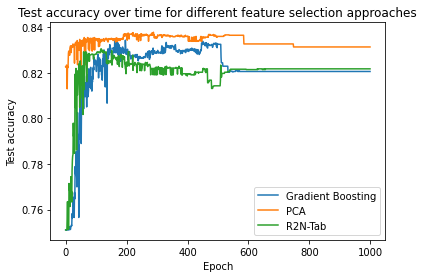

In [21]:
plt.plot(gb_acc)
plt.plot(pca_acc)
plt.plot(acc)
plt.title('Test accuracy over time for different feature selection approaches')
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.legend(['Gradient Boosting', 'PCA', 'R2N-Tab'])
plt.savefig('accfeatureselection.png')
plt.show()

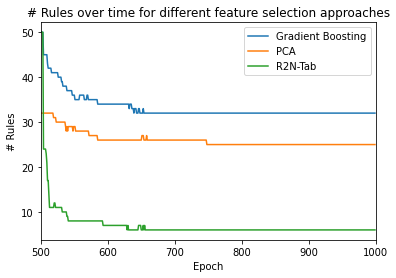

In [20]:
plt.plot(gb_rules)
plt.plot(pca_rules)
plt.plot(rules)
plt.title('# Rules over time for different feature selection approaches')
plt.xlabel('Epoch')
plt.ylabel('# Rules')
plt.legend(['Gradient Boosting', 'PCA', 'R2N-Tab'])
plt.xlim([500,1000])
plt.savefig('rulesfeatureselection.png')
plt.show()